In [1]:
import os
import torch

# Set preferred device: use CUDA if available, else fallback to CPU
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

# Optional: lock to only one GPU (e.g., for DAM4SAM to avoid internal conflicts)
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
print(device)

cuda:6


In [3]:
import glob
import argparse
import shutil

import numpy as np
import cv2
from PIL import Image

from dam4sam_tracker import DAM4SAMTracker
from utils.visualization_utils import overlay_mask, overlay_rectangle
from utils.box_selector import BoxSelector

In [4]:
# Input video and output directory
'''

video_path = "/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/videos/bedroom.mp4"  # <- change this if needed
output_dir = "workspace/DAM4SAM/videos/bedroom"

os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = os.path.join(output_dir, f"{frame_idx:04d}.jpg")
    cv2.imwrite(frame_path, frame)
    frame_idx += 1

cap.release()
print(f"Extracted {frame_idx} frames to '{output_dir}'")

'''


'\n\nvideo_path = "/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/videos/bedroom.mp4"  # <- change this if needed\noutput_dir = "workspace/DAM4SAM/videos/bedroom"\n\nos.makedirs(output_dir, exist_ok=True)\n\ncap = cv2.VideoCapture(video_path)\nframe_idx = 0\n\nwhile cap.isOpened():\n    ret, frame = cap.read()\n    if not ret:\n        break\n    frame_path = os.path.join(output_dir, f"{frame_idx:04d}.jpg")\n    cv2.imwrite(frame_path, frame)\n    frame_idx += 1\n\ncap.release()\nprint(f"Extracted {frame_idx} frames to \'{output_dir}\'")\n\n'

In [5]:
frame_dir = "/media/RTCIN15TB/AllUsers/ALLIANCE-DC01-IMU_LBXR268-D-002_20240112_111253"
file_extension = "png"
output_dir = "./outputs/masks"

In [6]:
# Get frames
frames_dir = sorted(glob.glob(os.path.join(frame_dir, f'*.{file_extension}')))
if len(frames_dir) == 0:
    raise ValueError("No frames found!")

print(len(frames_dir))

450


In [7]:
# Instead of using BoxSelector (which causes the crash)
# Format: [x1, y1, x2, y2]
init_box = [100, 100, 300, 300]

In [8]:
# Select init box (user clicks)

if not init_box:
    raise ValueError("Initialization box not selected.")

In [9]:
# Create tracker
tracker = DAM4SAMTracker('sam21pp-L',device=device)

/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/sam2/modeling/sam/transformer.py:23: UserWarning: You are using PyTorch 2.1.0+cu121 without Flash Attention v2 support. Consider upgrading to PyTorch 2.2+ for Flash Attention v2 (which could be faster).
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
/media/RTCIN9TBA/Interns/RDT2/yai3kor/.cache/dam4sam_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(inst

In [10]:
# Prepare output folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
else:
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)

In [11]:
import torch
print("torch.cuda.device_count():", torch.cuda.device_count())
print("torch.cuda.current_device():", torch.cuda.current_device())
print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))

torch.cuda.device_count(): 10
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): Quadro RTX 5000


In [13]:
def highlight_mask(image, mask, color=(255, 255, 0), alpha=0.6):
    # Ensure input is in RGB
    image = np.array(image.convert("RGB"))
    
    # Ensure mask is boolean
    if mask.dtype != np.bool_:
        mask = mask.astype(bool)

    overlay = image.copy()
    color = np.array(color, dtype=np.uint8)
    overlay[mask] = ((1 - alpha) * overlay[mask] + alpha * color).astype(np.uint8)

    return overlay

/media/RTCIN9TBA/Interns/RDT2/yai3kor/.cache/dam4sam_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/sam2/sam2_video_predictor.py:1058: UserWarning: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other 

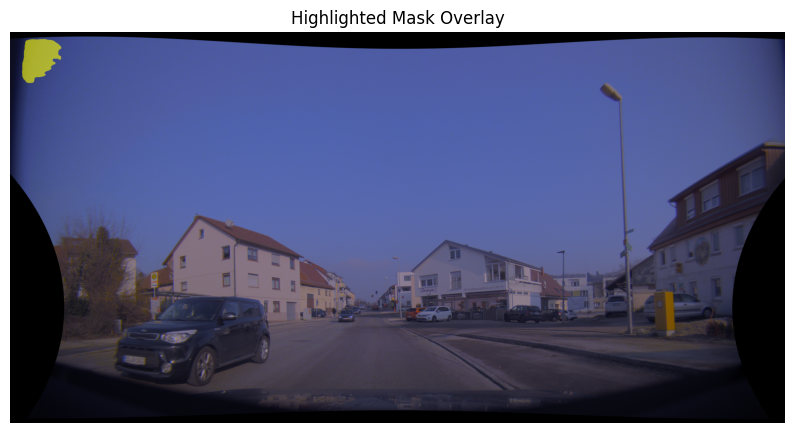

In [14]:
from PIL import Image
from dam4sam_tracker import DAM4SAMTracker

# Loading a single image
img_path = "/media/RTCIN15TB/AllUsers/ALLIANCE-DC01-IMU_LBXR268-D-002_20240112_111253/ALLIANCE-DC01-IMU_LBXR268-D-002_20240112_111253_FC1_f00003_RGB_ContextA_rectified.png"
img = Image.open(img_path)

#tracker = DAM4SAMTracker('sam21pp-B')

# Useing a fixed box instead of BoxSelector
init_box = [100, 100, 300, 300]

# Running single frame init + mask
outputs = tracker.initialize(img, None, bbox=init_box)
mask = outputs['pred_mask']
highlight_img=highlight_mask(img,mask)

# Display
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(highlight_img)
plt.axis('off')
plt.title("Highlighted Mask Overlay")
plt.show()


In [60]:
# Tracking over frames
print("Tracking...")
for i in range(len(frames_dir)):
    img = Image.open(frames_dir[i])

    if i == 0:
        outputs = tracker.initialize(img, None, bbox=init_box)
    else:
        outputs = tracker.track(img)

    pred_mask = outputs['pred_mask']  # binary mask
    highlighted_img = highlight_mask(img, pred_mask)  # overlay color on mask

    # Save the highlighted image
    frame_name = os.path.basename(frames_dir[i])
    dot_idx = frame_name.find('.')
    frame_name = frame_name[:dot_idx]
    output_path = os.path.join(output_dir, f'{frame_name}.png')
    cv2.imwrite(output_path, cv2.cvtColor(highlighted_img, cv2.COLOR_RGB2BGR))  # save in BGR format for OpenCV

print("Tracking complete. Highlighted masks saved to:", output_dir)

Tracking...
Tracking complete. Highlighted masks saved to: ./outputs/bedroom_masks


In [61]:
import cv2
import os
import glob

def frames_to_video(frame_dir, output_path, fps=10):
    frame_files = sorted(glob.glob(os.path.join(frame_dir, '*.png')))

    if not frame_files:
        print("No frames found in:", frame_dir)
        return

    # Read the first frame to get the dimensions
    frame = cv2.imread(frame_files[0])
    height, width, _ = frame.shape

    # Define video codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        out.write(frame)

    out.release()
    print(f"Video saved to: {output_path}")


In [62]:
total_frames=200
video_length_seconds=6
fps = total_frames / video_length_seconds

In [63]:
frames_to_video(output_dir, '/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/output_tracked_videos/bedroom_tracked.mp4', fps=fps)

Video saved to: /media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/output_tracked_videos/bedroom_tracked.mp4


In [ ]:
## Black and white mask
print("Tracking...")
for i in range(len(frames_dir)):
    img = Image.open(frames_dir[i])
    img_vis = np.array(img)

    if i == 0:
        outputs = tracker.initialize(img, None, bbox=init_box)
    else:
        outputs = tracker.track(img)

    pred_mask = outputs['pred_mask']
    highlighted = highlight_mask(img, pred_mask)
    frame_name = os.path.basename(frames_dir[i])
    dot_idx = frame_name.find('.')
    frame_name = frame_name[:dot_idx]
    output_path = os.path.join(output_dir, f'{frame_name}.png')
    cv2.imwrite(output_path, pred_mask * 255)

print("Tracking complete. Masks saved to:", output_dir)


In [64]:
from IPython.display import Video

In [65]:
video_path = '/media/RTCIN9TBA/Interns/RDT2/yai3kor/workspace/DAM4SAM/output_tracked_videos/bedroom_tracked.mp4'  
video = Video(video_path)

In [66]:
video